In [15]:
import torch
device = torch.device(torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu')\

device

device(type='cuda')

In [16]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics



class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, class_list, image_folder):
        self.file_class = class_list
        self.image_folder = image_folder

    def __len__(self):
        return len(self.file_class)
    
    def __getitem__(self, idx):
        image_name = self.file_class.iloc[idx, 0]
        image_path = f"{self.image_folder}/{image_name}"
        image = Image.open(image_path).convert('RGB')

        label = self.file_class.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)

        preprocessing = v2.Compose([
            v2.Resize((128, 128)),
            v2.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            v2.RandomGrayscale(p=0.1),
            v2.RandomErasing(p=0.3),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]).to(device)

        image = preprocessing(image)

        return image, label

# Dataset split

In [17]:
train_image_label = pd.read_csv('annot/train_info.csv', names=['image_name', 'label'])

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(train_image_label, train_size = 0.8, test_size=0.2, random_state=42)

reduced_train_df = []
for i in range(251):
    if train_df[train_df['label'] == i].shape[0] > 100:
        # If there are more than 200 samples, sample 100
        reduced_train_df.append(train_df[train_df['label'] == i].sample(100, random_state=42))
    else:
        # If there are less than 200 samples, take all available samples
        reduced_train_df.append(train_df[train_df['label'] == i])

reduced_train_df = pd.concat(reduced_train_df, ignore_index=True)

reduced_val_df = []
for i in range(251):
    if val_df[val_df['label'] == i].shape[0] > 30:
        # If there are more than 30 samples, sample 100
        reduced_val_df.append(val_df[val_df['label'] == i].sample(30, random_state=42))
    else:
        # If there are less than 30 samples, take all available samples
        reduced_val_df.append(val_df[val_df['label'] == i])

reduced_val_df = pd.concat(reduced_val_df, ignore_index=True)

c:\Users\eliau\OneDrive\Desktop\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.343704].


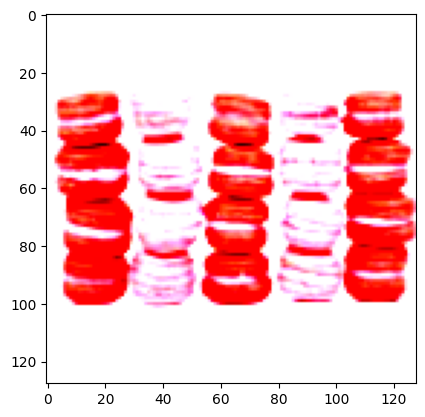

In [18]:
train_dataset = FoodDataset(reduced_train_df, 'train/train_set')
image_train, label_train = train_dataset.__getitem__(0)

plt.imshow(image_train.permute(1, 2, 0).numpy())

val_dataset = FoodDataset(reduced_val_df, 'train/train_set')
image_val, label_val = val_dataset.__getitem__(0)

In [19]:
test_df = pd.read_csv('annot/val_info.csv')

test_dataset = FoodDataset(test_df, 'val/val_set')
test_dataset.__getitem__(0)

c:\Users\eliau\OneDrive\Desktop\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


(tensor([[[-1.2103, -1.3644, -1.3815,  ...,  0.4679,  0.4851,  0.5022],
          [-0.6452, -0.9192, -1.1932,  ...,  0.4851,  0.5022,  0.5022],
          [-0.8507, -1.0904, -1.3473,  ...,  0.4851,  0.5022,  0.5193],
          ...,
          [ 0.2796,  0.2624,  0.2282,  ...,  0.1939,  0.2282,  0.2282],
          [ 0.2282,  0.2453,  0.2282,  ...,  0.1939,  0.1939,  0.2282],
          [ 0.2282,  0.2453,  0.2282,  ...,  0.1939,  0.1939,  0.2282]],
 
         [[-1.1253, -1.2654, -1.3004,  ...,  0.5903,  0.5903,  0.5728],
          [-0.5476, -0.8277, -1.1078,  ...,  0.5728,  0.5903,  0.5903],
          [-0.6877, -0.9328, -1.1954,  ...,  0.5378,  0.5553,  0.5903],
          ...,
          [ 0.3627,  0.3627,  0.3627,  ...,  0.2927,  0.3277,  0.3627],
          [ 0.3277,  0.3627,  0.3627,  ...,  0.2752,  0.3102,  0.3452],
          [ 0.3277,  0.3627,  0.3452,  ...,  0.2752,  0.2752,  0.3452]],
 
         [[-0.8633, -0.9853, -0.9678,  ...,  0.7054,  0.7228,  0.7054],
          [-0.3230, -0.5844,

In [20]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)  # pt = softmax prob of correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()


criterion = FocalLoss(alpha=0.25, gamma=2).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656862..1.7685405].


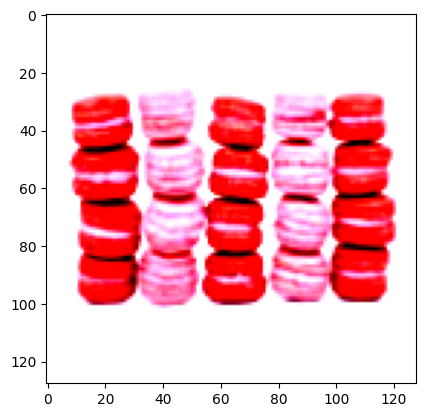

In [22]:
train_dataset = FoodDataset(reduced_train_df, 'train/train_set')
image_train, label_train = train_dataset.__getitem__(0)

plt.imshow(image_train.permute(1, 2, 0).numpy())

val_dataset = FoodDataset(reduced_val_df, 'train/train_set')
image_val, label_val = val_dataset.__getitem__(0)

In [23]:
import torch
import torch.nn as nn

# Optional: Squeeze-and-Excitation block to enhance channels
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.SiLU(),  # better than ReLU
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# Depthwise separable residual block with SE and SiLU
class ResidualDWBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_c, in_c, kernel_size=3, stride=stride, padding=1, groups=in_c),
            nn.BatchNorm2d(in_c),
            nn.SiLU(),
            nn.Conv2d(in_c, out_c, kernel_size=1),
            nn.BatchNorm2d(out_c),
            SEBlock(out_c)
        )
        self.skip = nn.Identity()
        if in_c != out_c or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_c)
            )
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.main(x) + self.skip(x))

# The full CNN model
class ResidualFoodCNN(nn.Module):
    def __init__(self, num_classes=251):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU()
        )

        self.layer1 = nn.Sequential(
            ResidualDWBlock(64, 128, stride=2),
            ResidualDWBlock(128, 128)
        )
        self.layer2 = nn.Sequential(
            ResidualDWBlock(128, 256, stride=2),
            ResidualDWBlock(256, 256)
        )
        self.layer3 = nn.Sequential(
            ResidualDWBlock(256, 512, stride=2),
            ResidualDWBlock(512, 512)
        )
        self.layer4 = nn.Sequential(
            ResidualDWBlock(512, 512),  # No further downsampling
            ResidualDWBlock(512, 512)
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.SiLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


In [24]:
cnn = ResidualFoodCNN(num_classes=251)
print(f"Total params: {sum(p.numel() for p in cnn.parameters() if p.requires_grad):,}")
cnn.to(device)

Total params: 2,191,019


ResidualFoodCNN(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (layer1): Sequential(
    (0): ResidualDWBlock(
      (main): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): SEBlock(
          (pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=128, out_features=8, bias=True)
            (1): SiLU()
            (2): Linear(in_features=8, out_features=128, bias=True)
            (3): Sigmoid()
          )
        )
      )
      (skip): Sequentia

In [ ]:
num_epochs = 50
optimizer = torch.optim.AdamW(cnn.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

shutil.rmtree('runs/food_classification', ignore_errors=True)
writer = SummaryWriter('runs/food_classification')

training_accuracy = torchmetrics.Accuracy(num_classes=251, task='multiclass').to(device)
validation_accuracy = torchmetrics.Accuracy(num_classes=251, task='multiclass').to(device)
criterion = nn.CrossEntropyLoss().to(device)

training_per_batch_losses = []
training_per_batch_accuracies = []
validation_per_batch_losses = []
validation_per_batch_accuracies = []

for epoch in range(num_epochs):


    cnn.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(tqdm(train_dataloader)):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = cnn(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        training_per_batch_losses.append(loss.item())
        training_per_batch_accuracies.append(training_accuracy(outputs, labels).item())

        # Logging
        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_dataloader) + i)

    # Compute and print epoch-level training metrics
    avg_train_loss = sum(training_per_batch_losses[-len(train_dataloader):]) / len(train_dataloader)
    avg_train_acc = sum(training_per_batch_accuracies[-len(train_dataloader):]) / len(train_dataloader)
    print(f"[Epoch {epoch+1}] Training Loss: {avg_train_loss:.4f} | Training Accuracy: {avg_train_acc*100:.2f}%")

    # 🔍 Validation
    cnn.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            validation_per_batch_losses.append(loss.item())
            validation_per_batch_accuracies.append(validation_accuracy(outputs, labels).item())

    avg_val_loss = sum(validation_per_batch_losses[-len(val_dataloader):]) / len(val_dataloader)
    avg_val_acc = sum(validation_per_batch_accuracies[-len(val_dataloader):]) / len(val_dataloader)
    print(f"[Epoch {epoch+1}] Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_acc*100:.2f}%")

    scheduler.step(avg_val_loss)


  0%|          | 0/392 [00:00<?, ?it/s]

100%|██████████| 392/392 [05:55<00:00,  1.10it/s]


[Epoch 1] Training Loss: 5.2052 | Training Accuracy: 2.21%


100%|██████████| 118/118 [01:33<00:00,  1.26it/s]


[Epoch 1] Validation Loss: 4.9443 | Validation Accuracy: 3.69%


100%|██████████| 392/392 [02:31<00:00,  2.59it/s]


[Epoch 2] Training Loss: 4.8123 | Training Accuracy: 4.95%


100%|██████████| 118/118 [00:34<00:00,  3.45it/s]


[Epoch 2] Validation Loss: 4.6900 | Validation Accuracy: 5.75%


100%|██████████| 392/392 [02:26<00:00,  2.67it/s]


[Epoch 3] Training Loss: 4.5572 | Training Accuracy: 7.65%


100%|██████████| 118/118 [00:34<00:00,  3.46it/s]


[Epoch 3] Validation Loss: 4.4609 | Validation Accuracy: 8.99%


100%|██████████| 392/392 [02:31<00:00,  2.60it/s]


[Epoch 4] Training Loss: 4.3672 | Training Accuracy: 9.88%


100%|██████████| 118/118 [00:35<00:00,  3.34it/s]


[Epoch 4] Validation Loss: 4.2960 | Validation Accuracy: 11.02%


 50%|█████     | 197/392 [01:15<01:15,  2.59it/s]

In [ ]:
import os

torch.save(cnn.state_dict(), 'food_classification_model.pth')

# Save the metrics
os.makedirs('metrics', exist_ok=True)

print("Number of training batches:", len(train_dataloader))
with open('metrics/training_per_batch_losses.txt', 'w') as f:
    for loss in training_per_batch_losses:
        f.write(f"{loss}\n")
with open('metrics/training_per_batch_accuracies.txt', 'w') as f:
    for acc in training_per_batch_accuracies:
        f.write(f"{acc}\n")

print("Number of validation batches:", len(val_dataloader))
with open('metrics/validation_per_batch_losses.txt', 'w') as f:
    for loss in validation_per_batch_losses:
        f.write(f"{loss}\n")
with open('metrics/validation_per_batch_accuracies.txt', 'w') as f:
    for acc in validation_per_batch_accuracies:
        f.write(f"{acc}\n")


In [ ]:
print(f"Batch output shape: {outputs.shape}")  # Should be (batch_size, 251)
print(f"Batch label shape: {labels.shape}")    # Should be (batch_size,)


Batch output shape: torch.Size([128, 251])
Batch label shape: torch.Size([128])


In [ ]:
accuracy = 100 * (correct / total)
print(f'Validation Accuracy: {accuracy:.2f}%')

Validation Accuracy: 19.99%


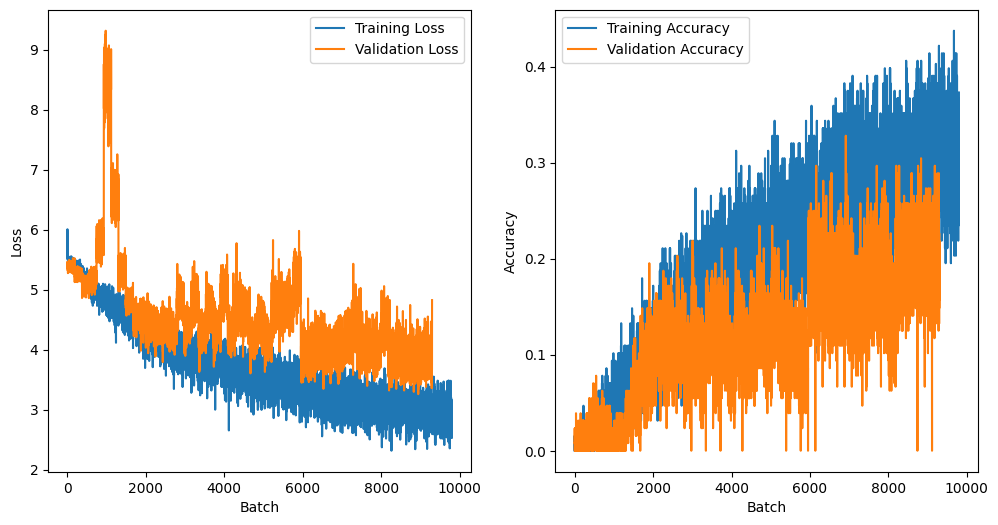

In [ ]:
#plot losses and accuracies
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_per_batch_losses, label='Training Loss')
plt.plot(validation_per_batch_losses, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(training_per_batch_accuracies, label='Training Accuracy')
plt.plot(validation_per_batch_accuracies, label='Validation Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
cnn.train()
images, labels = next(iter(train_dataloader))
images, labels = images.to(device), labels.to(device)

for i in range(200):
    optimizer.zero_grad()
    outputs = cnn(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    print(f"[{i}] Loss: {loss.item()}")


c:\Users\eliau\OneDrive\Desktop\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


[0] Loss: 1.3710373640060425
[1] Loss: 1.3704700469970703
[2] Loss: 1.3694629669189453
[3] Loss: 1.3680641651153564
[4] Loss: 1.3663169145584106
[5] Loss: 1.364259958267212
[6] Loss: 1.3619295358657837
[7] Loss: 1.3593573570251465
[8] Loss: 1.3565727472305298
[9] Loss: 1.3536016941070557
[10] Loss: 1.3504680395126343
[11] Loss: 1.3471933603286743
[12] Loss: 1.343796968460083
[13] Loss: 1.340295672416687
[14] Loss: 1.3367056846618652
[15] Loss: 1.3330409526824951
[16] Loss: 1.3293142318725586
[17] Loss: 1.325536847114563
[18] Loss: 1.3217190504074097
[19] Loss: 1.3178701400756836
[20] Loss: 1.3139983415603638
[21] Loss: 1.3101112842559814
[22] Loss: 1.306215524673462
[23] Loss: 1.3023170232772827
[24] Loss: 1.2984213829040527
[25] Loss: 1.2945330142974854
[26] Loss: 1.2906568050384521
[27] Loss: 1.2867960929870605
[28] Loss: 1.2829545736312866
[29] Loss: 1.2791354656219482
[30] Loss: 1.275341272354126
[31] Loss: 1.2715744972229004
[32] Loss: 1.2678372859954834
[33] Loss: 1.2641317844390